In [13]:
import pandas as pd
#from pathlib import Path
import numpy
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
from IPython.display import Image, display

In [3]:
from utils_v2 import *
from kg_gen_5 import *

In [4]:
import os
print(os.getcwd())

C:\Users\reagon.karki\Documents\GitHub\advise_workshop\src


In [5]:
compound_df  = pd.read_csv('../data/ecbd.csv')

In [6]:
compound_df.head()

,eos,smiles,inchi,inchikey,formula,mw,hba,hbd,tpsa,rb,fp3,logp,violates_ro5,pubchem,chembl,zinc
0,EOS100001,CC[C@]1(O)C[C@@H]2CN(CCc3c([nH]c4ccccc34)[C@@]...,InChI=1S/C46H56N4O10.H2O4S/c1-7-42(55)22-28-23...,AQTQHPDCURKLKT-PNYVAJAMSA-N,C46H58N4O14S,923.051,18,5,245.77,8,0.565,2.865,1,CID5388992,NaN,NaN
1,EOS100002,CC(C)(C)NC(=O)[C@H]1CC[C@H]2[C@@H]3CC[C@H]4NC(...,"InChI=1S/C23H36N2O2/c1-21(2,3)25-20(27)17-8-7-...",DBEPLOCGEIEOCV-WSBQPABSSA-N,C23H36N2O2,372.553,4,2,58.20,1,0.826,3.815,0,CID57363,CHEMBL710,ZINC000003782599
2,EOS100005,O=C1[C@H](CC[C@H](O)c2ccc(F)cc2)[C@@H](c2ccc(O...,InChI=1S/C24H21F2NO3/c25-17-5-1-15(2-6-17)22(2...,OLNTVTPDXPETLC-XPWALMASSA-N,C24H21F2NO3,409.432,4,2,60.77,6,0.208,4.888,0,CID150311,CHEMBL1138,ZINC000003810860
3,EOS100007,CC(C)C(=O)c1c(C(C)C)nn2ccccc12,InChI=1S/C14H18N2O/c1-9(2)13-12(14(17)10(3)4)1...,ZJVFLBOZORBYFE-UHFFFAOYSA-N,C14H18N2O,230.311,3,0,34.37,3,0.429,3.296,0,CID3671,CHEMBL19449,ZINC000000004234
4,EOS100008,Cl.c1ccc2c(CC3=NCCN3)cccc2c1,InChI=1S/C14H14N2.ClH/c1-2-7-13-11(4-1)5-3-6-1...,DJDFFEBSKJCGHC-UHFFFAOYSA-N,C14H15ClN2,246.741,2,1,24.39,2,0.214,2.806,0,CID11079;43834266;43834388;657295,CHEMBL1706,NaN


In [7]:
len(compound_df)

669

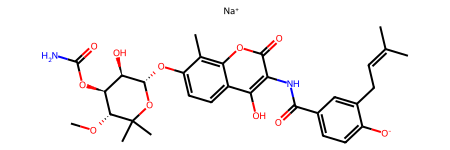

In [9]:
Chem.MolFromSmiles(compound_df['smiles'][50])

In [ ]:
compound_df['smiles'] = [removeSalt(Chem.MolFromSmiles(x)) for x in list(compound_df['smiles'])]

# Part 1 - Clustering compounds

In [10]:
# Create molecules from SMILES and store in array
compounds = []
# .itertuples() returns a (index, column1, column2, ...) tuple per row
# we don't need index so we use _ instead
# note how we are slicing the dataframe to only the two columns we need now
for _, chembl_id, smiles in compound_df[["eos", "smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), chembl_id))
compounds[:5]

[(<rdkit.Chem.rdchem.Mol at 0x1c1e8201b30>, 'EOS100001'),
 (<rdkit.Chem.rdchem.Mol at 0x1c1e82019e0>, 'EOS100002'),
 (<rdkit.Chem.rdchem.Mol at 0x1c1e8201820>, 'EOS100005'),
 (<rdkit.Chem.rdchem.Mol at 0x1c1e8201270>, 'EOS100007'),
 (<rdkit.Chem.rdchem.Mol at 0x1c1e8201430>, 'EOS100008')]

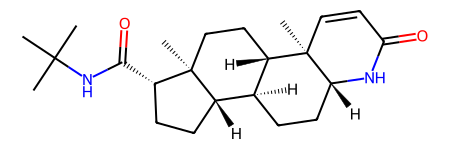

In [11]:
compounds[1][0]

In [12]:
# Create fingerprints for all molecules
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
fingerprints = [rdkit_gen.GetFingerprint(mol) for mol, idx in compounds]

# How many compounds/fingerprints do we have?
print("Number of compounds converted:", len(fingerprints))
print("Fingerprint length per compound:", len(fingerprints[0]))
# NBVAL_CHECK_OUTPUT

Number of compounds converted: 669
Fingerprint length per compound: 2048


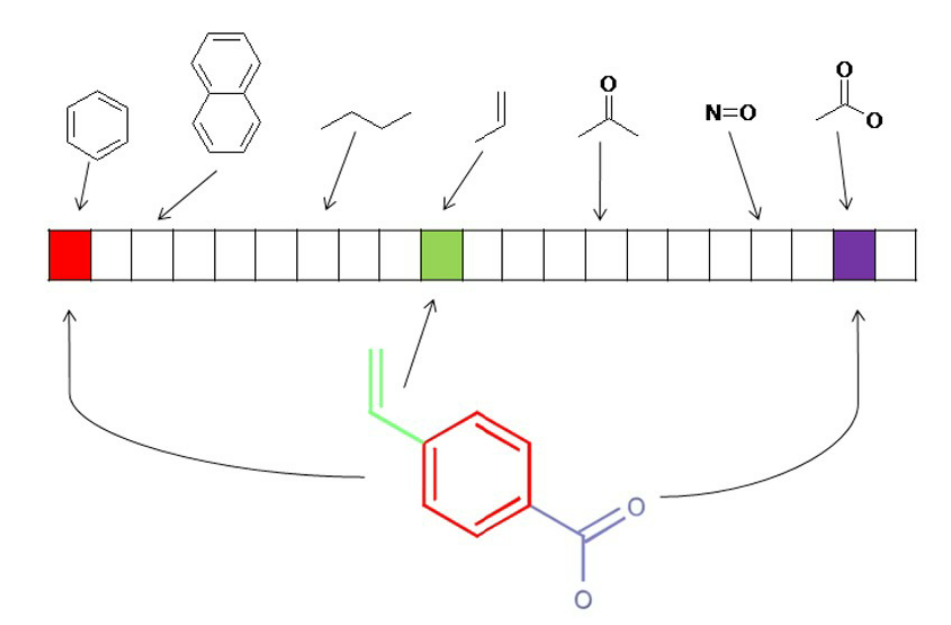

In [17]:
display(Image(filename='../data/fingerprint.PNG', width=400, height=400))

In [18]:
def tanimoto_distance_matrix(fp_list):
    """Calculate distance matrix for fingerprint list"""
    dissimilarity_matrix = []
    # Notice how we are deliberately skipping the first and last items in the list
    # because we don't need to compare them against themselves
    for i in range(1, len(fp_list)):
        # Compare the current fingerprint against all the previous ones in the list
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([1 - x for x in similarities])
    return dissimilarity_matrix

In [19]:
# Example: Calculate single similarity of two fingerprints
# NBVAL_CHECK_OUTPUT
sim = DataStructs.TanimotoSimilarity(fingerprints[0], fingerprints[7])
print(f"Tanimoto similarity: {sim:.2f}, distance: {1-sim:.2f}")

Tanimoto similarity: 0.26, distance: 0.74


In [20]:
# Example: Calculate distance matrix (distance = 1-similarity)
tanimoto_distance_matrix(fingerprints)[0:5]

[0.8323765786452354,
 0.7124868835257083,
 0.8275862068965517,
 0.7700534759358288,
 0.9214780600461894]

In [21]:
# Side note: That looked like a list and not a matrix.
# But it is a triangular similarity matrix in the form of a list
n = len(fingerprints)

# Calculate number of elements in triangular matrix via n*(n-1)/2
elem_triangular_matr = (n * (n - 1)) / 2
print(
    f"Elements in the triangular matrix ({elem_triangular_matr:.0f}) ==",
    f"tanimoto_distance_matrix(fingerprints) ({len(tanimoto_distance_matrix(fingerprints))})",
)
# NBVAL_CHECK_OUTPUT

Elements in the triangular matrix (223446) == tanimoto_distance_matrix(fingerprints) (223446)


In [24]:
def cluster_fingerprints(fingerprints, cutoff=0.2):
    """Cluster fingerprints
    Parameters:
        fingerprints
        cutoff: threshold for the clustering
    """
    # Calculate Tanimoto distance matrix
    distance_matrix = tanimoto_distance_matrix(fingerprints)
    # Now cluster the data with the implemented Butina algorithm:
    clusters = Butina.ClusterData(distance_matrix, len(fingerprints), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True)
    return clusters

In [25]:
# Run the clustering procedure for the dataset
clusters = cluster_fingerprints(fingerprints, cutoff=0.8)

# Give a short report about the numbers of clusters and their sizes
num_clust_g1 = sum(1 for c in clusters if len(c) == 1)
num_clust_g5 = sum(1 for c in clusters if len(c) > 5)
num_clust_g25 = sum(1 for c in clusters if len(c) > 25)
num_clust_g50 = sum(1 for c in clusters if len(c) > 50)
num_clust_g100 = sum(1 for c in clusters if len(c) > 100)

print("total # clusters: ", len(clusters))
print("# clusters with only 1 compound: ", num_clust_g1)
print("# clusters with >5 compounds: ", num_clust_g5)
print("# clusters with >25 compounds: ", num_clust_g25)
print("# clusters with >50 compounds: ", num_clust_g50)
print("# clusters with >100 compounds: ", num_clust_g100)
# NBVAL_CHECK_OUTPUT

total # clusters:  36
# clusters with only 1 compound:  14
# clusters with >5 compounds:  10
# clusters with >25 compounds:  5
# clusters with >50 compounds:  2
# clusters with >100 compounds:  1


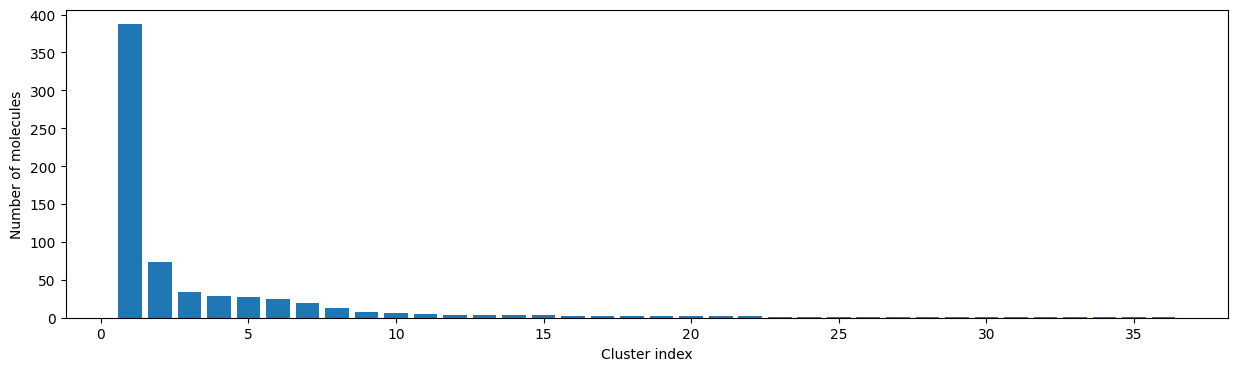

In [26]:
# Plot the size of the clusters
fig, ax = plt.subplots(figsize=(15, 4))
ax.set_xlabel("Cluster index")
ax.set_ylabel("Number of molecules")
ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5);

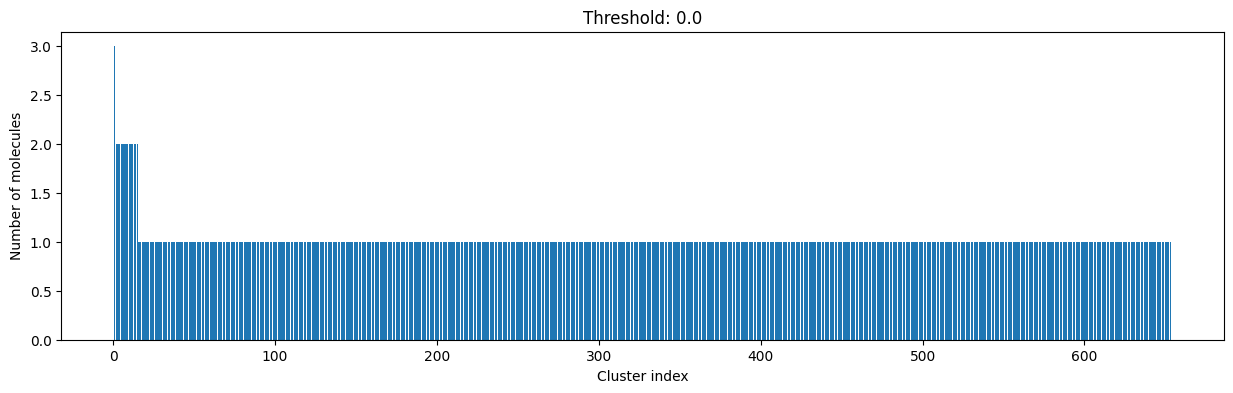

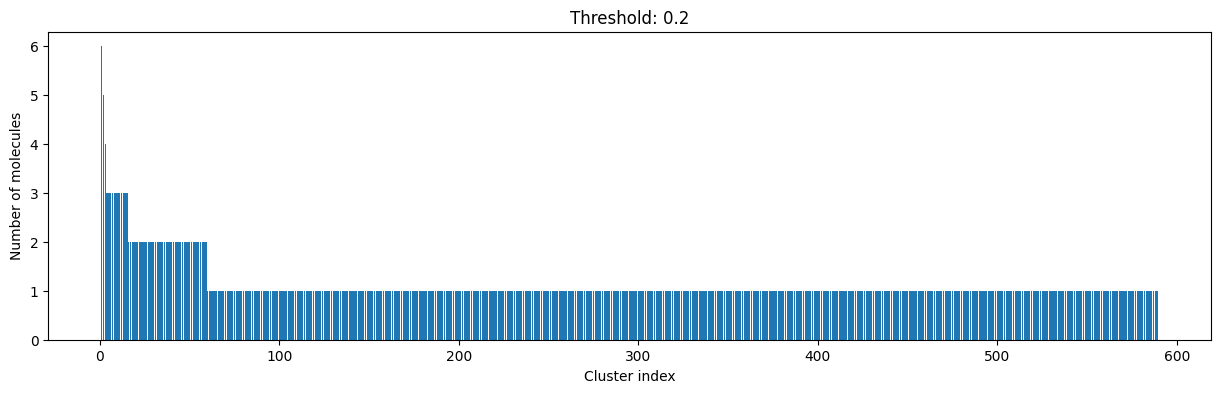

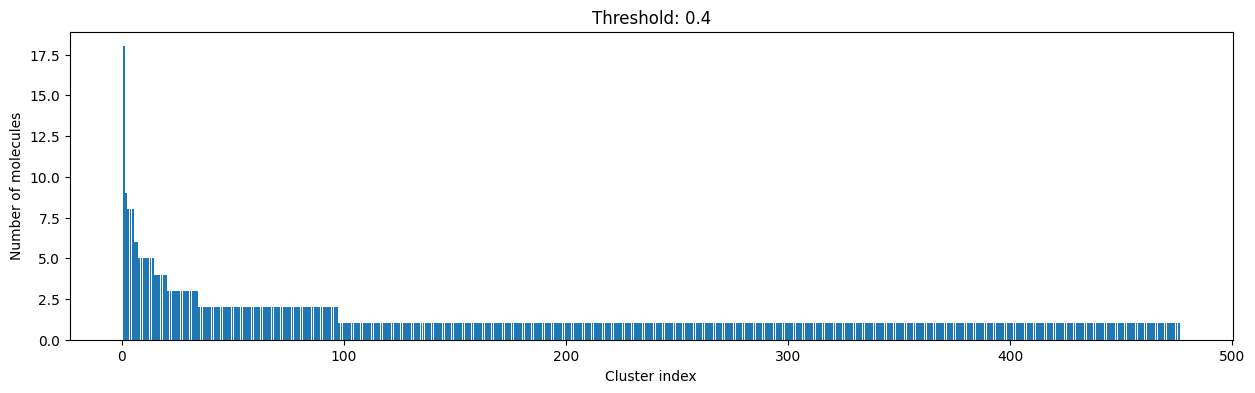

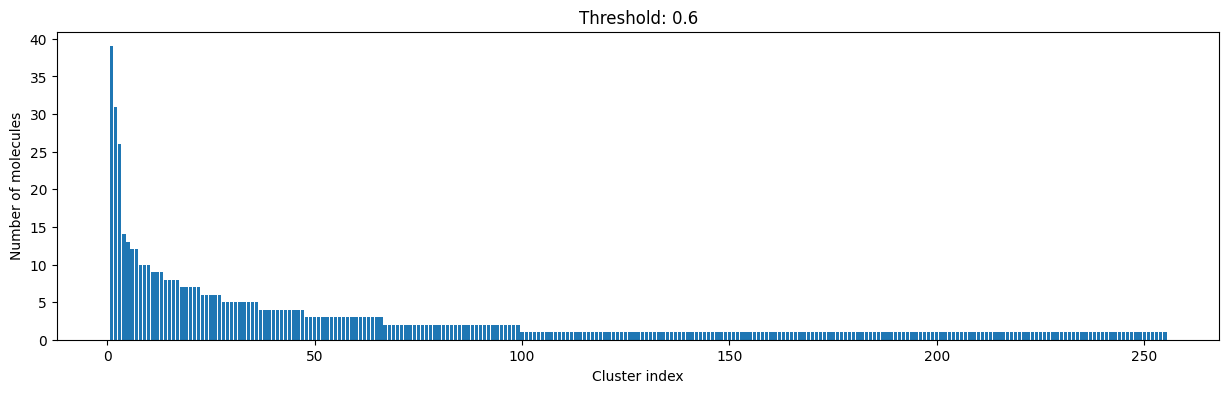

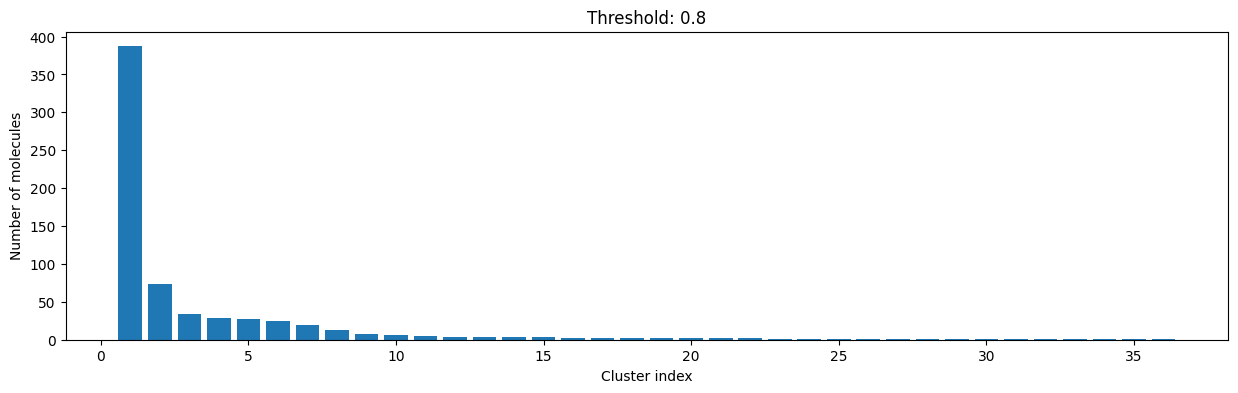

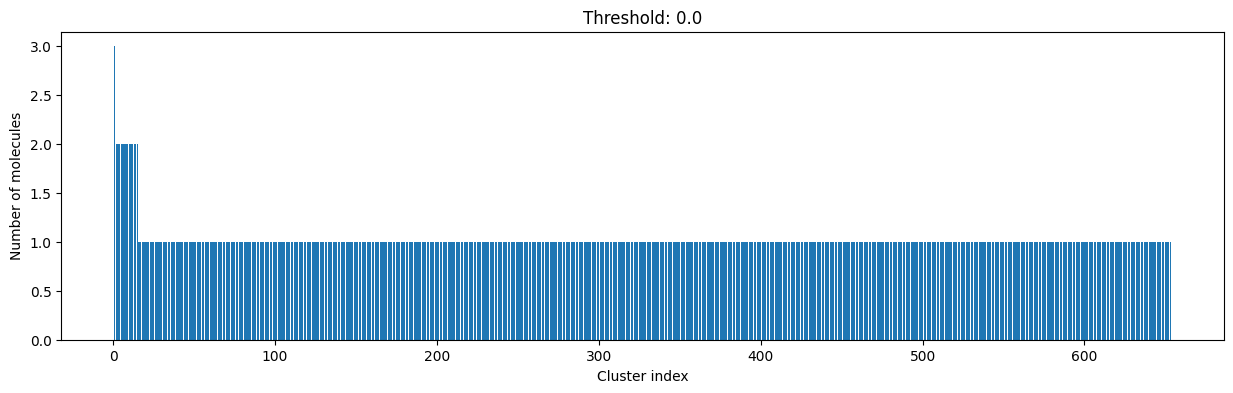

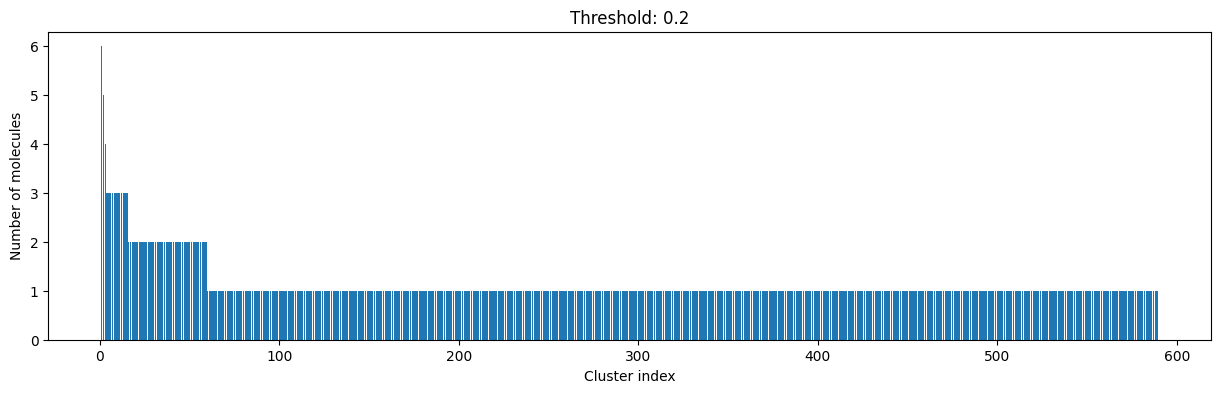

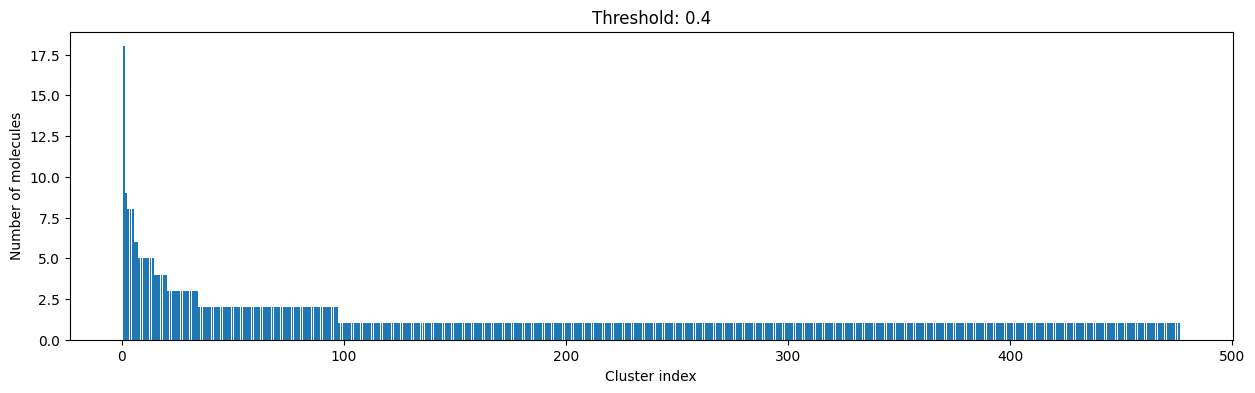

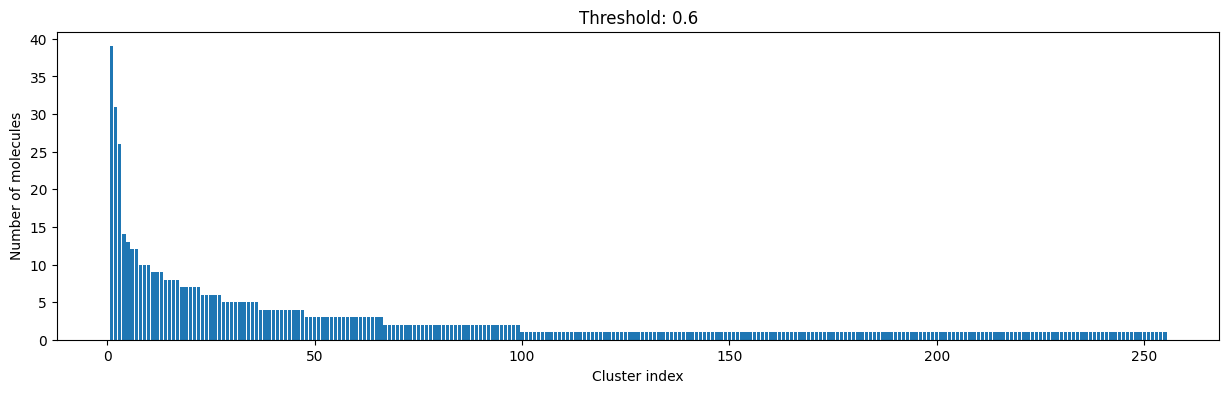

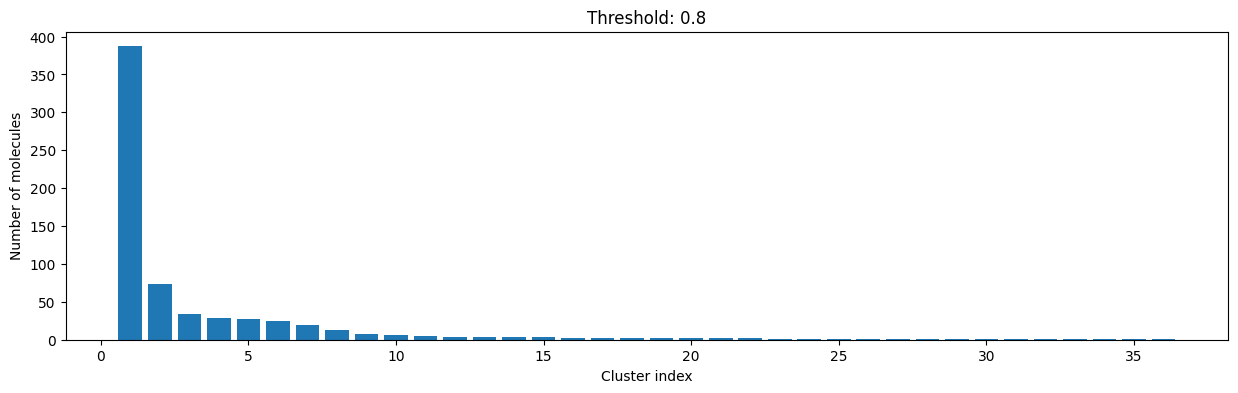

In [27]:
for cutoff in numpy.arange(0.0, 1.0, 0.2):
    clusters = cluster_fingerprints(fingerprints, cutoff=cutoff)
    fig, ax = plt.subplots(figsize=(15, 4))
    ax.set_title(f"Threshold: {cutoff:3.1f}")
    ax.set_xlabel("Cluster index")
    ax.set_ylabel("Number of molecules")
    ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5)
    display(fig)

Number of clusters: 476 from 669 molecules at distance cut-off 0.40
Number of molecules in largest cluster: 18
Similarity between two random points in same cluster: 0.88
Similarity between two random points in different cluster: 0.20


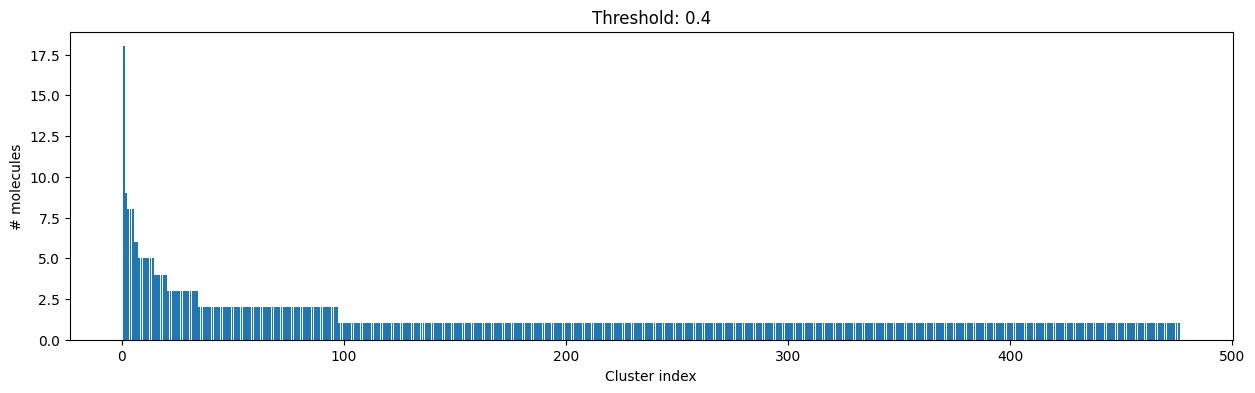

In [40]:
from pathlib import Path
cutoff = 0.4
clusters = cluster_fingerprints(fingerprints, cutoff=cutoff)

DATA = Path('../data')

# Plot the size of the clusters - save plot
fig, ax = plt.subplots(figsize=(15, 4))
ax.set_xlabel("Cluster index")
ax.set_ylabel("# molecules")
ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters])
ax.set_title(f"Threshold: {cutoff:3.1f}")
fig.savefig(
    DATA / f"cluster_dist_cutoff_{cutoff:4.2f}.png",
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)

print(
    f"Number of clusters: {len(clusters)} from {len(compounds)} molecules at distance cut-off {cutoff:.2f}"
)
print("Number of molecules in largest cluster:", len(clusters[0]))
print(
    f"Similarity between two random points in same cluster: {DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]], fingerprints[clusters[0][1]]):.2f}"
)
print(
    f"Similarity between two random points in different cluster: {DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]], fingerprints[clusters[1][0]]):.2f}"
)

Ten molecules from largest cluster:


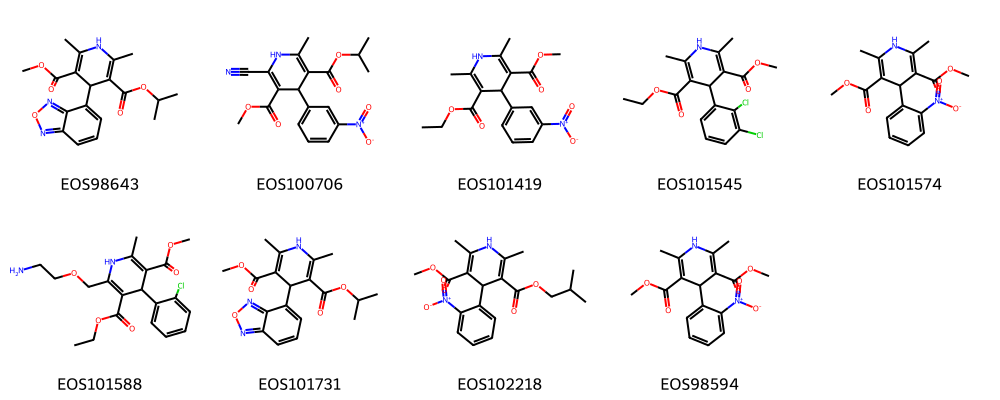

In [42]:
print("Ten molecules from largest cluster:")
# Draw molecules
Draw.MolsToGridImage(
    [compounds[i][0] for i in clusters[1][:10]],
    legends=[compounds[i][1] for i in clusters[1][:10]],
    molsPerRow=5,
)

# Part 2 - Druglikeness Assessment

In [ ]:
#chembl = [x for x in chembl if str(x) != 'nan']

In [43]:
compound_df.head()

,eos,smiles,inchi,inchikey,formula,mw,hba,hbd,tpsa,rb,fp3,logp,violates_ro5,pubchem,chembl,zinc
0,EOS100001,CC[C@]1(O)C[C@@H]2CN(CCc3c([nH]c4ccccc34)[C@@]...,InChI=1S/C46H56N4O10.H2O4S/c1-7-42(55)22-28-23...,AQTQHPDCURKLKT-PNYVAJAMSA-N,C46H58N4O14S,923.051,18,5,245.77,8,0.565,2.865,1,CID5388992,NaN,NaN
1,EOS100002,CC(C)(C)NC(=O)[C@H]1CC[C@H]2[C@@H]3CC[C@H]4NC(...,"InChI=1S/C23H36N2O2/c1-21(2,3)25-20(27)17-8-7-...",DBEPLOCGEIEOCV-WSBQPABSSA-N,C23H36N2O2,372.553,4,2,58.20,1,0.826,3.815,0,CID57363,CHEMBL710,ZINC000003782599
2,EOS100005,O=C1[C@H](CC[C@H](O)c2ccc(F)cc2)[C@@H](c2ccc(O...,InChI=1S/C24H21F2NO3/c25-17-5-1-15(2-6-17)22(2...,OLNTVTPDXPETLC-XPWALMASSA-N,C24H21F2NO3,409.432,4,2,60.77,6,0.208,4.888,0,CID150311,CHEMBL1138,ZINC000003810860
3,EOS100007,CC(C)C(=O)c1c(C(C)C)nn2ccccc12,InChI=1S/C14H18N2O/c1-9(2)13-12(14(17)10(3)4)1...,ZJVFLBOZORBYFE-UHFFFAOYSA-N,C14H18N2O,230.311,3,0,34.37,3,0.429,3.296,0,CID3671,CHEMBL19449,ZINC000000004234
4,EOS100008,Cl.c1ccc2c(CC3=NCCN3)cccc2c1,InChI=1S/C14H14N2.ClH/c1-2-7-13-11(4-1)5-3-6-1...,DJDFFEBSKJCGHC-UHFFFAOYSA-N,C14H15ClN2,246.741,2,1,24.39,2,0.214,2.806,0,CID11079;43834266;43834388;657295,CHEMBL1706,NaN


In [44]:
df = compound_df[compound_df['chembl'].notna()]
df.reset_index(inplace=True)

In [45]:
df['drugId'] = list(df['chembl'])

C:\Users\reagon.karki\AppData\Local\Temp\ipykernel_31300\1106823435.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['drugId'] = list(df['chembl'])


In [46]:
def calculate_filters(df_smiles):
    
    #df_smiles = GetSmiles(df,colname_chembl)
    
    #df_smiles = remove_salt(df_smiles,'smiles')
    
    temp = ro5_filter(df_smiles)
    temp = ghose_filter(temp)
    temp = veber_filter(temp)
    temp = reos_filter(temp)
    temp = qed_filter(temp)
    
    return(temp)
    
    df = df.loc[df.groupby('drugId')['phase'].idxmax()]
    df = df.reset_index(drop=True)
    
    df = pd.merge(temp,df[['drugId','phase']],on='drugId', how='left')
    
    df[['phase']] = df[['phase']].astype(int)
    
    df = df.drop_duplicates()
    df = df.reset_index(drop=True)
    
    return(df)

In [47]:
get_filters = calculate_filters(df)

C:\Users\reagon.karki\Documents\GitHub\advise_workshop\src\kg_gen_5.py:1304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Violation(s)_ro5'] = violation_counts_list
C:\Users\reagon.karki\Documents\GitHub\advise_workshop\src\kg_gen_5.py:1305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lipinski_ro5'] = pass_list


In [48]:
get_filters

,index,eos,smiles,inchi,inchikey,formula,mw,hba,hbd,tpsa,rb,fp3,logp,violates_ro5,pubchem,chembl,zinc,drugId,Violation(s)_ro5,Lipinski_ro5,MW,HBA,HBD,LogP,Ghose,AtomNum,MolRefractivity,Veber,RotBond,TPSA,REOS,Charge,HeavyAtom,QED,RingNum
0,1,EOS100002,CC(C)(C)NC(=O)[C@H]1CC[C@H]2[C@@H]3CC[C@H]4NC(...,"InChI=1S/C23H36N2O2/c1-21(2,3)25-20(27)17-8-7-...",DBEPLOCGEIEOCV-WSBQPABSSA-N,C23H36N2O2,372.553,4,2,58.20,1,0.826,3.815,0,CID57363,CHEMBL710,ZINC000003782599,CHEMBL710,0,0,372.553,4,2,3.815,0,27,106.842,0,1,58.20,0,0,27,0,4
1,2,EOS100005,O=C1[C@H](CC[C@H](O)c2ccc(F)cc2)[C@@H](c2ccc(O...,InChI=1S/C24H21F2NO3/c25-17-5-1-15(2-6-17)22(2...,OLNTVTPDXPETLC-XPWALMASSA-N,C24H21F2NO3,409.432,4,2,60.77,6,0.208,4.888,0,CID150311,CHEMBL1138,ZINC000003810860,CHEMBL1138,0,0,409.432,4,2,4.888,0,30,108.818,0,6,60.77,0,0,30,1,4
2,3,EOS100007,CC(C)C(=O)c1c(C(C)C)nn2ccccc12,InChI=1S/C14H18N2O/c1-9(2)13-12(14(17)10(3)4)1...,ZJVFLBOZORBYFE-UHFFFAOYSA-N,C14H18N2O,230.311,3,0,34.37,3,0.429,3.296,0,CID3671,CHEMBL19449,ZINC000000004234,CHEMBL19449,0,0,230.311,3,0,3.296,1,17,68.450,0,3,34.37,0,0,17,0,2
3,4,EOS100008,Cl.c1ccc2c(CC3=NCCN3)cccc2c1,InChI=1S/C14H14N2.ClH/c1-2-7-13-11(4-1)5-3-6-1...,DJDFFEBSKJCGHC-UHFFFAOYSA-N,C14H15ClN2,246.741,2,1,24.39,2,0.214,2.806,0,CID11079;43834266;43834388;657295,CHEMBL1706,NaN,CHEMBL1706,0,0,246.741,2,1,2.806,1,17,75.205,0,2,24.39,0,0,17,0,3
4,5,EOS100010,NC(=O)OCC(COC(N)=O)c1ccccc1,InChI=1S/C11H14N2O4/c12-10(14)16-6-9(7-17-11(1...,WKGXYQFOCVYPAC-UHFFFAOYSA-N,C11H14N2O4,238.243,6,4,104.64,5,0.273,0.961,0,CID3331,CHEMBL1094,ZINC000001530803,CHEMBL1094,0,0,238.243,6,4,0.961,1,17,60.254,0,5,104.64,0,0,17,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,664,EOS98594,COC(=O)C1=C(C)NC(C)=C(C(=O)OC)C1c1ccccc1[N+](=...,InChI=1S/C17H18N2O6/c1-9-13(16(20)24-3)15(14(1...,HYIMSNHJOBLJNT-UHFFFAOYSA-N,C17H18N2O6,346.339,8,1,107.77,4,0.294,2.176,0,CID4485,CHEMBL193,ZINC000085205448,CHEMBL193,0,0,346.339,8,1,2.176,0,25,88.405,0,4,107.77,0,0,25,0,2
638,665,EOS98599,O=c1[nH]cc(F)c(=O)[nH]1,"InChI=1S/C4H3FN2O2/c5-2-1-6-4(9)7-3(2)8/h1H,(H...",GHASVSINZRGABV-UHFFFAOYSA-N,C4H3FN2O2,130.078,4,2,65.72,0,0.000,-0.798,0,CID3385,CHEMBL185,ZINC000038212689,CHEMBL185,0,0,130.078,4,2,-0.798,1,9,27.641,0,0,65.72,1,0,9,0,1
639,666,EOS98605,COc1cc([C@@H]2c3cc4c(cc3[C@@H](O[C@@H]3O[C@@H]...,InChI=1S/C29H32O13/c1-11-36-9-20-27(40-11)24(3...,VJJPUSNTGOMMGY-MRVIYFEKSA-N,C29H32O13,588.562,13,3,160.83,5,0.552,1.339,1,CID36462,CHEMBL44657,ZINC000003938684,CHEMBL44657,2,1,588.562,13,3,1.339,1,42,138.345,1,5,160.83,1,0,42,1,7
640,667,EOS98643,COC(=O)C1=C(C)NC(C)=C(C(=O)OC(C)C)C1c1cccc2nonc12,InChI=1S/C19H21N3O5/c1-9(2)26-19(24)15-11(4)20...,HMJIYCCIJYRONP-UHFFFAOYSA-N,C19H21N3O5,371.393,8,1,103.55,4,0.368,2.582,0,CID3784,CHEMBL1648,NaN,CHEMBL1648,0,0,371.393,8,1,2.582,0,27,96.325,0,4,103.55,0,0,27,0,3


In [ ]:
#Druglikeness chart

Lipinski:
    Moleculer Weight <= 500
    LogP <= 5
    H-Bond Donor Count <= 5
    H-Bond Acceptor Count <= 10
    
Ghose:
    Molecular weight between 160 and 480
    LogP between -0.4 and +5.6
    Atom count between 20 and 70
    Molar refractivity between 40 and 130
    
Veber:
    Rotatable bonds <= 10
    Topological polar surface area <= 140

REOS:
    Molecular weight between 200 and 500
    LogP between -5.0 and +5.0
    H-bond donor count between 0 and 5
    H-bond acceptor count between 0 and 10
    Formal charge between -2 and +2
    Rotatable bond count between 0 and 8
    Heavy atom count between 15 and 50

Drug-Like (QED):
    mass < 400
    ring count > 0
    rotatable bond count < 5
    h-bond donor count <= 5
    h-bond acceptor count <= 10
    logP < 5

In [49]:
def druglikeness(df,filename):
    
    #select cols with druglikness flags as 0 (Yes) and 1 (No)
    filter_cols = ['Lipinski_ro5','Ghose','Veber','REOS','QED']

    df = df[filter_cols]
    df = df.stack().groupby(level=[1]).value_counts().unstack()
    
    # Preferred order of stacked bar elements
    stack_order = [0, 1]
    df = df[stack_order]

    ax = df.plot.bar(rot=0, stacked=True,
                      figsize = [8,8],
                      title='Bar plots showing drug-likeness across various filters',
                      xlabel = 'Filters for drug-likeness',
                      ylabel = 'Total number of drugs',
                      #table = df,
                      linewidth = 4,
                      edgecolor='white', 
                      #grid = 2
                     )

    ax.set_facecolor("ghostwhite")
    #%matplotlib inline

    ax.set_axisbelow(True)
    ax.yaxis.grid(color='white', linewidth = 2)
    ax.legend(['Yes', "No"])
    
    path = '../data/' + filename + '.png'
    
    ax.get_figure().savefig(path, format='png', dpi = 600)

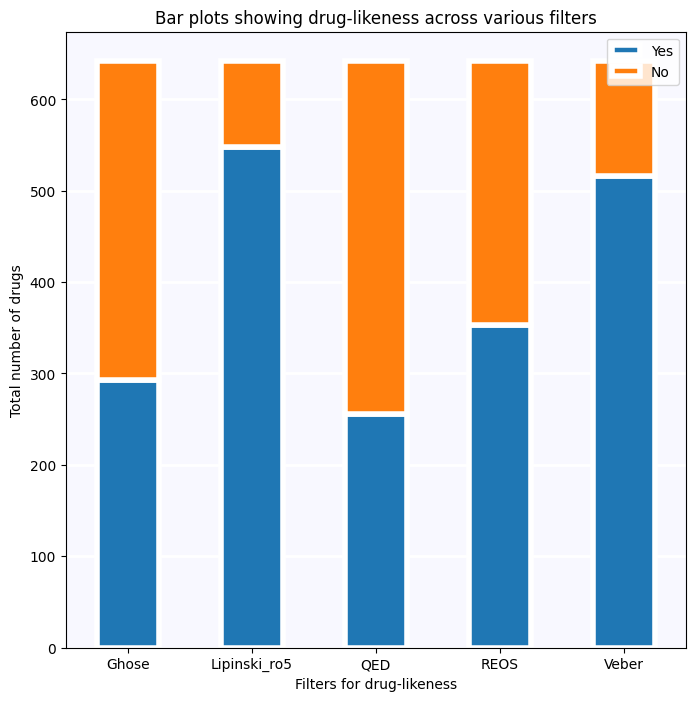

In [17]:
drugLike = druglikeness(get_filters,'ecbd')

In [50]:
filter_cols = ['Lipinski_ro5',
 'Ghose',
 'Veber',
 'REOS',
 'QED']

calc_filters = get_filters[filter_cols]

In [51]:
calc_filters['Flag'] = calc_filters.sum(axis=1, numeric_only=True)

C:\Users\reagon.karki\AppData\Local\Temp\ipykernel_31300\742645675.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calc_filters['Flag'] = calc_filters.sum(axis=1, numeric_only=True)


In [52]:
calc_filters

,Lipinski_ro5,Ghose,Veber,REOS,QED,Flag
0,0,0,0,0,0,0
1,0,0,0,0,1,1
2,0,1,0,0,0,1
3,0,1,0,0,0,1
4,0,1,0,0,0,1
...,...,...,...,...,...,...
637,0,0,0,0,0,0
638,0,1,0,1,0,2
639,1,1,1,1,1,5
640,0,0,0,0,0,0


In [53]:
calc_filters['SMILES'] = list(get_filters['smiles'])
calc_filters['eos'] = list(get_filters['eos'])

C:\Users\reagon.karki\AppData\Local\Temp\ipykernel_31300\1949817141.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calc_filters['SMILES'] = list(get_filters['smiles'])
C:\Users\reagon.karki\AppData\Local\Temp\ipykernel_31300\1949817141.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calc_filters['eos'] = list(get_filters['eos'])


In [54]:
calc_filters

,Lipinski_ro5,Ghose,Veber,REOS,QED,Flag,SMILES,eos
0,0,0,0,0,0,0,CC(C)(C)NC(=O)[C@H]1CC[C@H]2[C@@H]3CC[C@H]4NC(...,EOS100002
1,0,0,0,0,1,1,O=C1[C@H](CC[C@H](O)c2ccc(F)cc2)[C@@H](c2ccc(O...,EOS100005
2,0,1,0,0,0,1,CC(C)C(=O)c1c(C(C)C)nn2ccccc12,EOS100007
3,0,1,0,0,0,1,Cl.c1ccc2c(CC3=NCCN3)cccc2c1,EOS100008
4,0,1,0,0,0,1,NC(=O)OCC(COC(N)=O)c1ccccc1,EOS100010
...,...,...,...,...,...,...,...,...
637,0,0,0,0,0,0,COC(=O)C1=C(C)NC(C)=C(C(=O)OC)C1c1ccccc1[N+](=...,EOS98594
638,0,1,0,1,0,2,O=c1[nH]cc(F)c(=O)[nH]1,EOS98599
639,1,1,1,1,1,5,COc1cc([C@@H]2c3cc4c(cc3[C@@H](O[C@@H]3O[C@@H]...,EOS98605
640,0,0,0,0,0,0,COC(=O)C1=C(C)NC(C)=C(C(=O)OC(C)C)C1c1cccc2nonc12,EOS98643


In [55]:
#drugType figure
#df_drugType = calc_filters
df_drugType = calc_filters.groupby(['Flag'])['Flag'].count().reset_index(name='count')

df_drugType = df_drugType.rename(index={0: 'PassedAllFilters', 1: '1 violation', 2:'2 violations', 3: '3 violations',
                                       4:'4 violations',5:'5 violations'})

fig = px.pie(df_drugType, values='count', names=df_drugType.index)
fig.update_layout(title_text='Druglikeness Assessment', title_x=0.45)

path_img = '../data/ecbd_druglikeness.png'
fig.write_image(path_img,scale=5)

path_html = '../data/ecbd_druglikeness.html'
plotly.offline.plot(fig, filename= path_html)

'../data/ecbd_druglikeness.html'

In [56]:
passAll = calc_filters.loc[calc_filters['Flag'] == 0]
passAll['Type'] = 'PassedAllFilters'
len(passAll)

C:\Users\reagon.karki\AppData\Local\Temp\ipykernel_31300\356065841.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



115

In [57]:
failAll = calc_filters.loc[calc_filters['Flag'] == 5]
failAll['Type'] = 'FailedAllFilters'
len(failAll)

C:\Users\reagon.karki\AppData\Local\Temp\ipykernel_31300\2229500095.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



65

In [58]:
rest = calc_filters.loc[(calc_filters['Flag'] > 0) & (calc_filters['Flag'] < 5)]
rest['Type'] = 'Rest'
len(rest)

C:\Users\reagon.karki\AppData\Local\Temp\ipykernel_31300\3891353788.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



462

In [59]:
final_df = pd.concat([passAll,failAll,rest], axis=0)

In [ ]:
len(final_df)

In [ ]:
final_df = final_df.reset_index(drop=True)

In [ ]:
final_df.to_csv('../data/ecbd_umap.csv',index=0)